## Semi-structured and Multi-modal RAG

Many documents contain a mixture of content types, including text, tables, and images. 

Semi-structured data can be challenging for conventional RAG for at least two reasons: 

* Text splitting may break up tables, corrupting the data in retrieval
* Embedding tables may pose challenges for semantic similarity search

And the information captured in images is typically lost.

With the emergence of multimodal LLMs, like [GPT4-V](https://openai.com/research/gpt-4v-system-card), it is worth considering how to utilize images in RAG:

`Option 1:` 

* Use multimodal embeddings (such as [CLIP](https://openai.com/research/clip)) to embed images and text
* Retrieve both using similarity search
* Pass raw images and text chunks to a multimodal LLM for answer synthesis 

`Option 2:` 

* Use a multimodal LLM (such as [GPT4-V](https://openai.com/research/gpt-4v-system-card), [LLaVA](https://llava.hliu.cc/), or [FUYU-8b](https://www.adept.ai/blog/fuyu-8b)) to produce text summaries from images
* Embed and retrieve text 
* Pass text chunks to an LLM for answer synthesis 

`Option 3:` 

* Use a multimodal LLM (such as [GPT4-V](https://openai.com/research/gpt-4v-system-card), [LLaVA](https://llava.hliu.cc/), or [FUYU-8b](https://www.adept.ai/blog/fuyu-8b)) to produce text summaries from images
* Embed and retrieve image summaries with a reference to the raw image 
* Pass raw images and text chunks to a multimodal LLM for answer synthesis   

This cookbook show how we might tackle this :

* We will use [Unstructured](https://unstructured.io/) to parse images, text, and tables from documents (PDFs).
* We will use the [multi-vector retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector) to store raw tables, text, (optionally) images along with their summaries for retrieval.
* We will demonstrate `Option 2`, and will follow-up on the other approaches in future cookbooks.

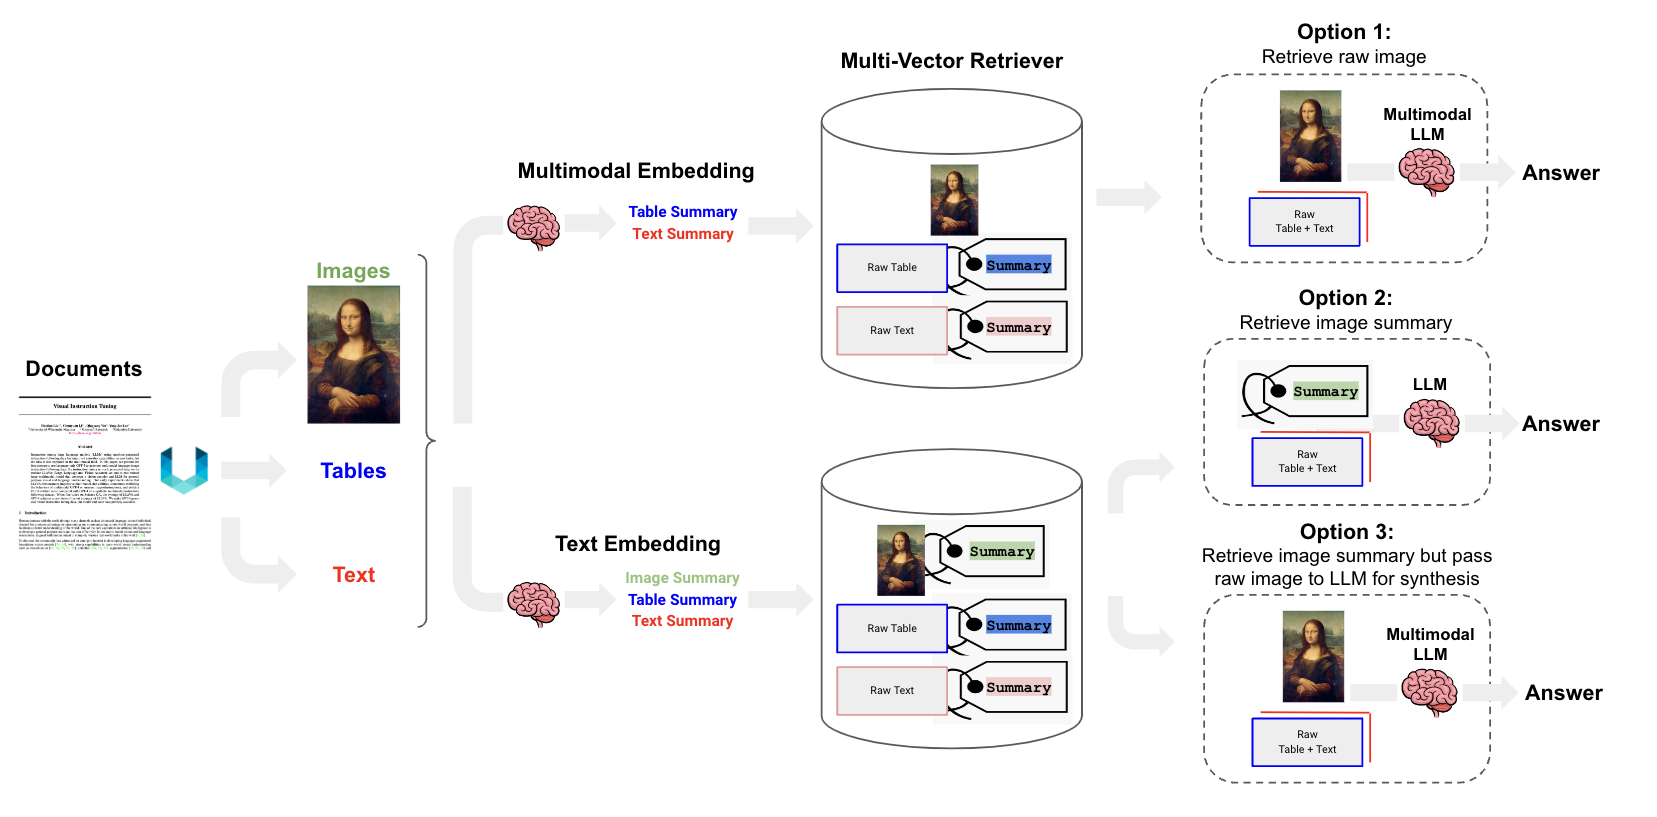

## Packages

In [ ]:
! pip install langchain unstructured[all-docs] pydantic lxml

## Data Loading

### Partition PDF tables, text, and images
  
* `LLaVA` Paper: https://arxiv.org/pdf/2304.08485.pdf
* Use [Unstructured](https://unstructured-io.github.io/unstructured/) to partition elements

In [1]:
path = "/Users/rlm/Desktop/Papers/LLaVA/"

In [33]:
from langchain.document_loaders import (
    UnstructuredExcelLoader,
    PyPDFLoader,
    UnstructuredWordDocumentLoader,
    UnstructuredPowerPointLoader,
    UnstructuredFileLoader,
)

In [9]:
path="../coockbook/"

In [10]:
from typing import Any

from pydantic import BaseModel
from unstructured.partition.pdf import partition_pdf

# Get elements
raw_pdf_elements = partition_pdf(
    filename="../stuff.pdf",
    # Using pdf format to find embedded image blocks
    extract_images_in_pdf=True,
    # Use layout model (YOLOX) to get bounding boxes (for tables) and find titles
    # Titles are any sub-section of the document
    infer_table_structure=True,
    # Post processing to aggregate text once we have the title
    chunking_strategy="by_title",
    # Chunking params to aggregate text blocks
    # Attempt to create a new chunk 3800 chars
    # Attempt to keep chunks > 2000 chars
    # Hard max on chunks
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=path,
)

The PDF <_io.BufferedReader name='../stuff.pdf'> contains a metadata field indicating that it should not allow text extraction. Ignoring this field and proceeding. Use the check_extractable if you want to raise an error in this case
The PDF <_io.BufferedReader name='../stuff.pdf'> contains a metadata field indicating that it should not allow text extraction. Ignoring this field and proceeding. Use the check_extractable if you want to raise an error in this case
Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or wi

In [14]:
unique=raw_pdf_elements

 
Enablon, a subsidiary of Wolters Kluwer  Enablon Hosted Solution System 
System and Organization Controls Report  Report on Controls Placed in Operation and Tests of Operating Effectiveness Relevant to Security  For the Period  May 1, 2022, to April 30, 2023 
ENABLON

TABLE OF CONTENTS

IV. Trust Services Criteria, Enablon’s Related Controls, and

I. Independent Service Auditor’s Report ........................................... 1 II. Enablon’s Assertion ......................................................................... 5 III. Enablon’s Description of Its Hosted Solution System .................. 6 Overview of Operations .................................................................................................................... 6 Background ................................................................................................................................ 6 Overview of Services Provided ......................................................................

In [17]:
# Create a dictionary to store counts of each type
category_counts = {}

for element in raw_pdf_elements:
    category = str(type(element))
    if category in category_counts:
        category_counts[category] += 1
    else:
        category_counts[category] = 1

# Unique_categories will have unique elements
unique_categories = set(category_counts.keys())
category_counts

{"<class 'unstructured.documents.elements.CompositeElement'>": 111,
 "<class 'unstructured.documents.elements.Table'>": 49}

In [18]:
class Element(BaseModel):
    type: str
    text: Any


# Categorize by type
categorized_elements = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        categorized_elements.append(Element(type="table", text=str(element)))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        categorized_elements.append(Element(type="text", text=str(element)))

# Tables
table_elements = [e for e in categorized_elements if e.type == "table"]
print(len(table_elements))

# Text
text_elements = [e for e in categorized_elements if e.type == "text"]
print(len(text_elements))

49
111


In [22]:
lpo=table_elements[0]

In [32]:
lpo.__dict__

{'type': 'table',
 'text': 'Independent Report ........:ccccsseeeeessseeeeeseeneeeees Enablon’s ASSEStion .........ccccceceeeeeeeeeeeeeeeeeeeeceeeeeeaseeeeeeeeseeeeeeeaeeeeaeeeees 5 Enablon’s Description of Its Hosted Solution System............. 6 Overview of Operations... cece eee eee eee ee tees ee eetecee eee seseeeeesesaeeeesesaeesesesaeeeeesesaeeeeevesaeeeeses Background Overview of Services Provided... Scope of Report and Boundaries of the System Principal Service Commitments and System Requirements Components of the System Used to Provide the Service ... Data.... System Incidents .... Changes to the System During the Period «00.0.0... ee eee teense rece eens teeneneeetenneneeetenaeel Relevant Aspects of the Control Environment, Risk Assessment Process, Information and Communication Systems, and Monitoring Controls... cece eee eee eeeeeeteeeeeeeteeeneeeteneenees 14 Control Environment Risk Assessment Process Information and Communication Systems Monitoring Controls ... Controls 

In [43]:
import os
import json
from langchain.document_loaders.csv_loader import CSVLoader
from langchain.document_loaders import (
    UnstructuredExcelLoader,
    PyPDFLoader,
    UnstructuredWordDocumentLoader,
    UnstructuredPowerPointLoader,
    UnstructuredFileLoader,
)
from langchain.text_splitter import RecursiveCharacterTextSplitter
import pathlib
from fastapi import HTTPException


from typing import Optional, List


class ChunkingException(Exception):
    pass


class FileLoaderException(Exception):
    pass


class FileProcessor:
    def __init__(
        self,
        filename: str,
        chunk_size: int,
        chunk_overlap: int,
        cust_metadata: dict,
        separators: Optional[List[str]] = ["\n\n", "\n", " ", ""],
    ):
        self.filename = filename
        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap
        self.separators = separators or ["\n\n", "\n", " ", ""]
        self.cust_metadata = cust_metadata
        self.file_type = ".pdf"
        self.is_unstructured_loader_enabled = json.loads(os.getenv("UNSTRUCTURED_LOADER_ENABLED", "false").lower())

    def _filetype_identification(self):
        return pathlib.Path(self.filename).suffix

    def _updating_metadata_for_word(self, doc_list: list):
        """This function takes list of dict containing metadata as an input"""

        """returns an updated metadata containing page number in it"""
        final_list = []
        for index_number, item in enumerate(doc_list):
            item["page"] = index_number
            final_list.append(item)
        return final_list

    def _get_documents(self):
        """This function load the documents in list by taking filename as argument"""
        try:
            if self.file_type == ".xlsx":
                loader = UnstructuredExcelLoader(self.filename, mode="elements")
            elif self.file_type == ".csv":
                loader = CSVLoader(self.filename)
            elif self.file_type == ".pdf":
                loader = PyPDFLoader(self.filename, extract_images=False)
            elif self.file_type == ".docx":
                loader = UnstructuredWordDocumentLoader(self.filename)
            elif self.file_type == ".pptx":
                loader = UnstructuredPowerPointLoader(self.filename, mode="elements")
            else:
                raise FileLoaderException("Unsupported file format")

            pages = loader.load()
            documents = self._get_documents_chunk(pages)
            return documents

        except Exception as e:
           
            raise FileLoaderException(f"Errored while loading the document: {str(e)}")

    def _table_title_merge(self, pages):
        """This function processes a list of pages, merging the content of pages labeled as 'Table' with the preceding 'Title' pages if they share the same page number."""
        
        i = 1
        while i < len(pages):
            current_page = pages[i]
            previous_page = pages[i - 1]

            current_page_number = current_page.metadata.get("page_number")
            previous_page_number = previous_page.metadata.get("page_number")

            if (
                current_page.metadata.get("category") == "Table"
                and previous_page.metadata.get("category") == "Title"
                and current_page_number == previous_page_number
            ):
                current_page.page_content = (
                    f"{previous_page.page_content} {current_page.page_content}"
                )
                current_page.metadata.pop("text_as_html", None)
                pages.pop(i - 1)
                i = max(0, i - 1)
            else:
                i += 1

        return pages

    def _get_table_text_elements(self, pages):
        """This function segregates pages into two lists, table_elements and text_elements, based on their category ('Table' or other)."""
        
        table_elements = []
        text_elements = []

        for page in pages:
            if page.metadata["category"] == "Table":
                table_elements.append(page)
            else:
                text_elements.append(page)

        return table_elements, text_elements

    def _process_and_refine_text_elements(self, text_elements):
        """This method processes a list of text elements, identifying consecutive pages with the same page number. If a page is categorized as "NarrativeText," it combines its content with the preceding page's content, excluding redundant occurrences. The method uses a set of indices to track and delete redundant pages while updating their metadata and content accordingly."""
        
        temptext = ""
        delete_indices = set([])

        for i in range(1, len(text_elements)):
            prev_page = text_elements[i - 1]
            current_page = text_elements[i]

            # condition to check the page_number of the previous and current page
            if current_page.metadata.get("page_number") == prev_page.metadata.get(
                "page_number"
            ):
                if (
                    current_page.metadata.get("category") == "NarrativeText"
                ):  # is a narrativeText
                    if prev_page.metadata.get("category") == "NarrativeText":
                        continue
                    else:  # prev not narrative
                        delete_indices.add(i - 1)

                        # Concatenate page content based on the existence of temptext
                        if temptext != "":
                            current_page.page_content = (
                                temptext + " " + current_page.page_content
                            )
                        else:
                            current_page.page_content = (
                                prev_page.page_content + " " + current_page.page_content
                            )
                        temptext = ""
                else:  # not a NarrativeText
                    delete_indices.add(i)

                    # Concatenate page content of both pages and add the index of the previous page to delete_indices set
                    if prev_page.metadata.get("category") == "NarrativeText":
                        temptext += (
                            prev_page.page_content + " " + current_page.page_content
                        )
                        delete_indices.add(i - 1)
                    else:
                        temptext += " " + current_page.page_content
            else:
                if temptext != "":
                    prev_page.metadata["category"] = "NarrativeText"
                    prev_page.page_content = temptext
                    temptext = ""
                    delete_indices.remove(i - 1)

        # Deleting indices which are not required
        delete_indices = list(delete_indices)
        delete_indices.sort(reverse=True)

        for index in delete_indices:
            del text_elements[index]

        return text_elements

    def _process_unstructured_metadata(self, text_elements, table_elements):
        """This code selectively retains only the desired keys in the metadata of both text_elements and table_elements"""

        desired_keys = ["source", "page_number", "category"]

        for element in text_elements:
            element.metadata = {
                key: element.metadata[key]
                for key in desired_keys
                if key in element.metadata
            }

        for element in table_elements:
            element.metadata = {
                key: element.metadata[key]
                for key in desired_keys
                if key in element.metadata
            }

        # Renaming 'page_number' as 'page'
        for page in text_elements:
            page.metadata["page"] = page.metadata.pop("page_number")
        for page in table_elements:
            page.metadata["page"] = page.metadata.pop("page_number")

        return text_elements, table_elements

    def _get_documents_from_unstructured_loader(self):
        """This function load the documents by taking filename as argument and processes them."""

        loader = UnstructuredFileLoader(
            self.filename, mode="elements", strategy="hi_res"
        )
        pages = loader.load()

        # Logic for adding previous Titles to tables if exists
        pages = self._table_title_merge(pages)

        # Logic to separating table and text elements
        table_elements, text_elements = self._get_table_text_elements(pages)

        # Logic for merging among text_elements
        text_elements = self._process_and_refine_text_elements(text_elements)

        # Cleaning metadata
        text_elements, table_elements = self._process_unstructured_metadata(
            text_elements, table_elements
        )

        # Chunking the text_elements
        documents = self._get_documents_chunk(text_elements)

        # Concatenating un-chunked table_elements to chunked text_elements
        documents.extend(table_elements)

        return documents

    def _get_documents_chunk(self, pages):
        "this function returns the chunks and metadata based on chunk size and overlap by taking list of document as argument"
        try:
            text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
                chunk_size=self.chunk_size,
                chunk_overlap=self.chunk_overlap,
                separators=self.separators,
            )
            return text_splitter.split_documents(pages)

        except Exception as e:
            
            raise ChunkingException(f"Error while creating the chunks: {str(e)}")

    def _get_page_metadata(self, metadata, keys_to_exclude_for_ppt, batch=0):
        """This function returns the updated metadata by stacking the custom metadata received in the request"""
        updated_metadata = []

        for index, item in enumerate(metadata):
            custom_metadata = {}
            for key, value in item.items():
                if key in keys_to_exclude_for_ppt:
                    pass
                else:
                    if key == "page" and self.file_type in [".pdf", ".docx"]:
                        custom_metadata[key] = value + 1
                    elif key == "page_number" and self.file_type in [".pptx", ".ppt"]:
                        custom_metadata["page"] = value
                    else:
                        custom_metadata[key] = value

            custom_metadata = {
                **dict(custom_metadata.items()),
                **dict(self.cust_metadata.items()),
                "batch": batch,
                "chunk_no": index,
            }

            updated_metadata.append(custom_metadata)

        return updated_metadata

    async def process_files(self):
        """This function is the main function which is responsible to process the files and return the page contents and metadata
        with flag that says we need to ingest in loop or directly once"""
        try:

            documents = (
                self._get_documents_from_unstructured_loader()
                if self.is_unstructured_loader_enabled
                else self._get_documents()
            )

            large_file = False
            batch_size = 16
            len_texts = len(documents)
            keys_to_exclude_for_ppt = [
                "file_directory",
                "last_modified",
                "category",
                "filetype",
                "source",
                "text_as_html",
                "page_name",
            ]

            if len_texts <= batch_size:
                page_content = [document.page_content for document in documents]
                page_metadata = [document.metadata for document in documents]

                updated_metadata = (
                    self._updating_metadata_for_word(page_metadata)
                    if self.file_type == ".docx"
                    else page_metadata
                )

                metadata = self._get_page_metadata(
                    updated_metadata, keys_to_exclude_for_ppt
                )

            else:
                large_file = True
                page_content_list = [document.page_content for document in documents]
                page_metadata = [document.metadata for document in documents]
                page_content = [
                    page_content_list[i : i + 15]
                    for i in range(0, len(page_content_list), 15)
                ]
                metadata_sublists = [
                    page_metadata[i : i + 15] for i in range(0, len(page_metadata), 15)
                ]
                metadata = [
                    self._get_page_metadata(sublist, keys_to_exclude_for_ppt, batch=idx)
                    for idx, sublist in enumerate(metadata_sublists)
                ]

        except Exception as e:
            
            raise ChunkingException(f"Error while chunking the file, {str(e)}")

        return page_content, metadata, large_file


In [ ]:
# Assuming UnstructuredFileLoader is defined and correctly imported

class CategoryContentFetcher(UnstructuredFileLoader):
    def __init__(self, file_path, mode="elements", strategy="hi_res"):
        """
        Initializes the CategoryContentFetcher with file path, mode, and strategy.
        
        :param file_path: Path to the file to be processed.
        :param mode: Loading mode, passed to UnstructuredFileLoader.
        :param strategy: Strategy for loading, passed to UnstructuredFileLoader.
        """
        # Initialize the superclass with the file path and any other necessary parameters
        super().__init__(file_path, mode=mode, strategy=strategy)
        # Load the documents immediately or as per your requirement
        self.documents = self.load()  # Assuming load() is a method from UnstructuredFileLoader
        self.category_counts = self._calculate_category_counts()

    def _calculate_category_counts(self):
        """
        Calculates the counts of each category found in the documents.
        
        :return: A dictionary with categories as keys and their counts as values.
        """
        category_counts = {}
        for doc in self.documents:
            # Assuming each 'doc' has a 'metadata' attribute with a 'category' key
            category = doc.metadata.get('category')
            if category:
                category_counts[category] = category_counts.get(category, 0) + 1
        return category_counts

    # Optionally, override or extend other methods from UnstructuredFileLoader
    def enhance_table_content(self, documents):
        """
        Enhances the content of documents categorized as tables by organizing, sorting, and merging them
        based on their parent_id and page_number.
        
        :param documents: List of tuples, each containing page_content and metadata, to be enhanced.
        :return: A dictionary of merged contents by parent_id.
        """
        organized_docs = defaultdict(list)
        for content, metadata in documents:
            parent_id = metadata.get('parent_id', 'no_parent')  # Handle documents without a parent_id
            organized_docs[parent_id].append((content, metadata))
        
        # Ensure each group is sorted by page_number
        for parent_id in organized_docs:
            organized_docs[parent_id].sort(key=lambda x: x[1]['page_number'])
        
        # Step 2: Merge contents
        merged_contents = {}
        for parent_id, docs in organized_docs.items():
            # Simple string concatenation to merge document content
            merged_content = " ".join([doc[0] for doc in docs])
            merged_contents[parent_id] = merged_content
        
        # Return the merged contents organized by parent_id
        return merged_contents    


In [ ]:
from collections import defaultdict

class CategoryContentFetcher(UnstructuredFileLoader):
    # Assuming the rest of the class definition remains unchanged
    
    def enhance_table_content(self, documents):
        """
        Enhances the content of documents categorized as tables by organizing, sorting, and merging them
        based on their parent_id and page_number.
        
        :param documents: List of tuples, each containing page_content and metadata, to be enhanced.
        :return: A dictionary of merged contents by parent_id.
        """
        organized_docs = defaultdict(list)
        for content, metadata in documents:
            parent_id = metadata.get('parent_id', 'no_parent')  # Handle documents without a parent_id
            organized_docs[parent_id].append((content, metadata))
        
        # Ensure each group is sorted by page_number
        for parent_id in organized_docs:
            organized_docs[parent_id].sort(key=lambda x: x[1]['page_number'])
        
        # Step 2: Merge contents
        merged_contents = {}
        for parent_id, docs in organized_docs.items():
            # Simple string concatenation to merge document content
            merged_content = " ".join([doc[0] for doc in docs])
            merged_contents[parent_id] = merged_content
        
        # Return the merged contents organized by parent_id
        return merged_contents

    # Other methods remain unchanged...


In [31]:
def _get_documents_from_unstructured_loader(self):
    """This function load the documents by taking filename as argument and processes them."""

    loader = UnstructuredFileLoader(
        self.filename, mode="elements", strategy="hi_res"
    )
    pages = loader.load()

    # Logic for adding previous Titles to tables if exists
    pages = self._table_title_merge(pages)

    # Logic to separating table and text elements
    table_elements, text_elements = self._get_table_text_elements(pages)

    # Logic for merging among text_elements
    text_elements = self._process_and_refine_text_elements(text_elements)

    # Cleaning metadata
    text_elements, table_elements = self._process_unstructured_metadata(
        text_elements, table_elements
    )

    # Chunking the text_elements
    documents = self._get_documents_chunk(text_elements)

    # Concatenating un-chunked table_elements to chunked text_elements
    documents.extend(table_elements)

    return documents

<bound method BaseModel.dict of Element(type='table', text='Independent Report ........:ccccsseeeeessseeeeeseeneeeees Enablon’s ASSEStion .........ccccceceeeeeeeeeeeeeeeeeeeeceeeeeeaseeeeeeeeseeeeeeeaeeeeaeeeees 5 Enablon’s Description of Its Hosted Solution System............. 6 Overview of Operations... cece eee eee eee ee tees ee eetecee eee seseeeeesesaeeeesesaeesesesaeeeeesesaeeeeevesaeeeeses Background Overview of Services Provided... Scope of Report and Boundaries of the System Principal Service Commitments and System Requirements Components of the System Used to Provide the Service ... Data.... System Incidents .... Changes to the System During the Period «00.0.0... ee eee teense rece eens teeneneeetenneneeetenaeel Relevant Aspects of the Control Environment, Risk Assessment Process, Information and Communication Systems, and Monitoring Controls... cece eee eee eeeeeeteeeeeeeteeeneeeteneenees 14 Control Environment Risk Assessment Process Information and Communication Systems M

In [38]:
from dotenv import load_dotenv

In [39]:
load_dotenv()

True

In [41]:
file_type

'.pdf'

In [44]:
is_unstructured_loader_enabled = json.loads(os.getenv("UNSTRUCTURED_LOADER_ENABLED", "true").lower())
filename="stuff.pdf",
separators=None
cust_md={'name':filename,"associate":"multimodal"}
file_type = pathlib.Path("stuff.pdf").suffix
file_supported_type = [".docx", ".pptx", ".pdf", ".xlsx", ".csv"]
if file_type.lower() in file_supported_type:
    processor = FileProcessor(
        filename=filename,
        separators=separators,
        chunk_size=2000,
        chunk_overlap=100,
        cust_metadata=cust_md,
    )

    page_content, metadata, large_file = await processor.process_files()

ChunkingException: Error while chunking the file, expected str, bytes or os.PathLike object, not tuple

In [166]:
loader = UnstructuredFileLoader(
        "stuff.pdf", mode="elements", strategy="hi_res"
    )
pages = loader.load()


In [167]:
pages
from langchain.schema.document import Document

In [168]:
extracted_data = [(doc.page_content, doc.metadata) for doc in pages]


In [169]:
categories = [doc[1]['category'] for doc in extracted_data if 'category' in doc[1]]


In [170]:
len(categories)

1681

In [63]:
set(categories)

{'Footer',
 'Header',
 'Image',
 'ListItem',
 'NarrativeText',
 'Table',
 'Title',
 'UncategorizedText'}

In [67]:
class DocumentFilter:
    def __init__(self, documents):
        """
        Initializes the DocumentFilter with a list of documents.
        
        :param documents: List of Document instances.
        """
        self.documents = documents
        print(self.documents)

    def fetch_data_by_categories(self, categories):
        """
        Fetches page_content of documents that match the given categories.
        
        :param categories: A set or list of categories to filter by.
        :return: List of page_content strings from documents matching the categories.
        """
        categories_set = set(categories)  # Ensure categories is a set for efficient lookup
        filtered_page_contents = [
            doc.page_content for doc in self.documents
            if doc.metadata.get('category') in categories_set
        ]
        return filtered_page_contents


In [70]:
to_test_doc=DocumentFilter(pages)

[Document(page_content='Enablon, a subsidiary of Wolters Kluwer  Enablon Hosted Solution System ', metadata={'source': 'stuff.pdf', 'coordinates': {'points': ((188.83333333333334, 687.1666666666666), (188.83333333333334, 917.1666666666666), (1550.0, 917.1666666666666), (1550.0, 687.1666666666666)), 'system': 'PixelSpace', 'layout_width': 1700, 'layout_height': 2200}, 'filename': 'stuff.pdf', 'last_modified': '2024-02-24T16:11:51', 'filetype': 'application/pdf', 'page_number': 1, 'category': 'Image'}), Document(page_content='System and Organization Controls Report  Report on Controls Placed in Operation and Tests of Operating Effectiveness Relevant to Security  For the Period  May 1, 2022, to April 30, 2023 ', metadata={'source': 'stuff.pdf', 'coordinates': {'points': ((177.83333333333331, 1184.6666666666667), (177.83333333333331, 1622.9999999999998), (1538.8333333333333, 1622.9999999999998), (1538.8333333333333, 1184.6666666666667)), 'system': 'PixelSpace', 'layout_width': 1700, 'layou

In [71]:
pages

[Document(page_content='Enablon, a subsidiary of Wolters Kluwer  Enablon Hosted Solution System ', metadata={'source': 'stuff.pdf', 'coordinates': {'points': ((188.83333333333334, 687.1666666666666), (188.83333333333334, 917.1666666666666), (1550.0, 917.1666666666666), (1550.0, 687.1666666666666)), 'system': 'PixelSpace', 'layout_width': 1700, 'layout_height': 2200}, 'filename': 'stuff.pdf', 'last_modified': '2024-02-24T16:11:51', 'filetype': 'application/pdf', 'page_number': 1, 'category': 'Image'}),
 Document(page_content='System and Organization Controls Report  Report on Controls Placed in Operation and Tests of Operating Effectiveness Relevant to Security  For the Period  May 1, 2022, to April 30, 2023 ', metadata={'source': 'stuff.pdf', 'coordinates': {'points': ((177.83333333333331, 1184.6666666666667), (177.83333333333331, 1622.9999999999998), (1538.8333333333333, 1622.9999999999998), (1538.8333333333333, 1184.6666666666667)), 'system': 'PixelSpace', 'layout_width': 1700, 'layo

In [151]:
class CategoryContentFetcher:
    def __init__(self, documents):
        """
        Initializes the CategoryContentFetcher with a list of Document instances.
        
        :param documents: List of Document instances.
        """
        self.documents = documents
        self.category_counts = self._calculate_category_counts()

    def _calculate_category_counts(self):
        """
        Dynamically calculates the counts of each category found in the provided documents.
        
        :return: A dictionary with categories as keys and their counts as values.
        """
        category_counts = {}
        for doc in self.documents:
            # Extract category from document's metadata
            category = doc.metadata.get('category')
            # If a category is present, increment its count or initialize it
            if category:
                if category in category_counts:
                    category_counts[category] += 1
                else:
                    category_counts[category] = 1
        return category_counts    


    def fetch_content_by_category(self, category="Table"):
        """
        Fetches page_content of documents that have a specified category in their metadata.
        
        :param category: Category to filter the documents by. Default is "Table".
        :return: List of page_content strings from documents matching the specified category.
        """
        return [(doc.page_content, doc.metadata) for doc in self.documents if doc.metadata.get('category') == category]
    def get_category_counts(self):
        """
        Returns the calculated counts of each category.
        
        :return: A dictionary with categories as keys and their counts as values.
        """
        return self.category_counts

# Assuming the Document class is defined as follows:
class Document:
    def __init__(self, page_content, metadata):
        self.page_content = page_content
        self.metadata = metadata

# Example usage with a list of Document instances:

documents=pages
# Initialize the CategoryContentFetcher with the list of documents
content_fetcher = CategoryContentFetcher(documents)


# Fetch and print page_content of documents categorized as 'Table'


"{'Footer',\n 'Header',\n 'Image',\n 'ListItem',\n 'NarrativeText',\n 'Table',\n 'Title',\n 'UncategorizedText'}"

In [157]:
unique_cat_counts_dict=content_fetcher.get_category_counts()

In [162]:
unique_caty=list(unique_cat_counts_dict.keys())

In [163]:
for i in unique_caty:
    content_fetcher.fetch_content_by_category(i)

In [362]:
tree=content_fetcher.fetch_content_by_category('NarrativeText')

In [367]:
page_numbers_and_parent_ids = [doc[1]['coordinates'] for doc in tree]



In [370]:
zxcx=[doc[1] for doc in page_numbers_and_parent_ids]
len(zxcx)

KeyError: 1

In [372]:
page_numbers_and_parent_ids

[{'points': ((1428.9615478515625, 357.0699768066406),
   (1428.9615478515625, 380.9910583496094),
   (1561.87158203125, 380.9910583496094),
   (1561.87158203125, 357.0699768066406)),
  'system': 'PixelSpace',
  'layout_width': 1700,
  'layout_height': 2200},
 {'points': ((200.0, 423.6510925292969),
   (200.0, 457.1505126953125),
   (558.2932222222222, 457.1505126953125),
   (558.2932222222222, 423.6510925292969)),
  'system': 'PixelSpace',
  'layout_width': 1700,
  'layout_height': 2200},
 {'points': ((200.0, 483.8398742675781),
   (200.0, 516.9739379882812),
   (286.57099999999997, 516.9739379882812),
   (286.57099999999997, 483.8398742675781)),
  'system': 'PixelSpace',
  'layout_width': 1700,
  'layout_height': 2200},
 {'points': ((191.8909149169922, 547.4005555555556),
   (191.8909149169922, 862.7338888888889),
   (1510.8421630859375, 862.7338888888889),
   (1510.8421630859375, 547.4005555555556)),
  'system': 'PixelSpace',
  'layout_width': 1700,
  'layout_height': 2200},
 {'point

In [373]:
# Example list of cell dictionaries
cells = page_numbers_and_parent_ids

# Function to sort cells into a table structure
def sort_cells_into_table(cells):
    # Sort cells by the y-coordinate of their top-left corner to group them into rows
    sorted_cells = sorted(cells, key=lambda cell: cell['points'][0][1])
    
    # Initialize table structure
    table = []
    current_row_y = None
    row = []
    
    # Group cells by row based on their y-coordinate
    for cell in sorted_cells:
        cell_top_y = cell['points'][0][1]
        
        # If this is the first cell or if the cell is in a new row
        if current_row_y is None or cell_top_y > current_row_y + threshold:
            # If row is not empty, add it to the table
            if row:
                # Sort the row by the x-coordinate of the cells' top-left corner before adding
                row = sorted(row, key=lambda cell: cell['points'][0][0])
                table.append(row)
                row = []
            current_row_y = cell_top_y
        
        # Add the cell to the current row
        row.append(cell)
    
    # Add the last row to the table if it's not empty
    if row:
        row = sorted(row, key=lambda cell: cell['points'][0][0])
        table.append(row)
    
    return table

# You might need to adjust this threshold depending on the specifics of your documents
# It's used to determine if a cell is in a new row
threshold = 10

# Sort cells into a table
table = sort_cells_into_table(cells)

# Print the sorted table for verification
for row in table:
    print([cell['points'] for cell in row])


[((189.67919921875, 210.5563201904297), (189.67919921875, 401.0966796875), (1503.1288333333334, 401.0966796875), (1503.1288333333334, 210.5563201904297)), ((193.74099731445312, 212.0116666666667), (193.74099731445312, 244.7861328125), (493.6984558105469, 244.7861328125), (493.6984558105469, 212.0116666666667)), ((195.30343627929688, 212.17833333333323), (195.30343627929688, 399.82244873046875), (1495.6143798828125, 399.82244873046875), (1495.6143798828125, 212.17833333333323)), ((196.1242218017578, 211.13592529296875), (196.1242218017578, 241.0868682861328), (741.7932222222221, 241.0868682861328), (741.7932222222221, 211.13592529296875)), ((200.0, 211.49999999999994), (200.0, 244.9999999999998), (1507.0917777777777, 244.9999999999998), (1507.0917777777777, 211.49999999999994)), ((200.0, 211.49999999999994), (200.0, 244.9999999999998), (1483.656833333334, 244.9999999999998), (1483.656833333334, 211.49999999999994)), ((200.0, 212.17833333333323), (200.0, 272.01166666666677), (1487.625666

In [365]:
zxcx

[{'source': 'stuff.pdf',
  'coordinates': {'points': ((1428.9615478515625, 357.0699768066406),
    (1428.9615478515625, 380.9910583496094),
    (1561.87158203125, 380.9910583496094),
    (1561.87158203125, 357.0699768066406)),
   'system': 'PixelSpace',
   'layout_width': 1700,
   'layout_height': 2200},
  'filename': 'stuff.pdf',
  'last_modified': '2024-02-24T16:11:51',
  'filetype': 'application/pdf',
  'parent_id': '1bc903b2fed30b33dcea880679f1bc8b',
  'page_number': 3,
  'detection_class_prob': 0.3971767723560333,
  'category': 'NarrativeText'},
 {'source': 'stuff.pdf',
  'coordinates': {'points': ((200.0, 423.6510925292969),
    (200.0, 457.1505126953125),
    (558.2932222222222, 457.1505126953125),
    (558.2932222222222, 423.6510925292969)),
   'system': 'PixelSpace',
   'layout_width': 1700,
   'layout_height': 2200},
  'filename': 'stuff.pdf',
  'last_modified': '2024-02-24T16:11:51',
  'filetype': 'application/pdf',
  'parent_id': '1bc903b2fed30b33dcea880679f1bc8b',
  'page_

In [355]:
unique=len(set(tree))
total=len((tree))
print(unique,total)


TypeError: unhashable type: 'dict'

In [296]:


# Initialize a dictionary to track occurrences
occurrences = {}

# Track occurrences of each tuple
for item in page_numbers_and_parent_ids:
    occurrences[item] = occurrences.get(item, 0) + 1

# Print duplicate values and their number of occurrences
print("Duplicates and their occurrences:")
for item, count in occurrences.items():
    if count > 1:
        print(f"{item}: {count}")



Duplicates and their occurrences:
 The controls stated in the description operated effectively throughout the period May 1, 2022, to April: 2
The information audit director monitors compliance deviations and violations that result in deficiencies in internal control. Monitoring takes place such that deficiencies are ultimately resolved by management in a timely manner.: 2
CC1.1 COSO Principle 1: The entity demonstrates a commitment to integrity and ethical values.: 3
New hires are provided company policies that document employee responsibilities, including the code of conduct, upon hire. At the time of hire, personnel are required to review and affirm personnel policies.: 3
Exception noted. For one of 14 new hires selected, the employee did not review and affirm the personnel policies in a timely manner.: 3
Performance reviews are conducted annually to evaluate personnel on performance in meeting job responsibilities.: 3
A speak up policy with contact information to anonymously report

In [236]:
{'Footer',
 'Header',
 'Image',
 'ListItem',
 'NarrativeText',
 'Table',
 'Title',
 'UncategorizedText'}

{'Footer',
 'Header',
 'Image',
 'ListItem',
 'NarrativeText',
 'Table',
 'Title',
 'UncategorizedText'}

In [211]:
# Assuming 'tree' is your list of tuples with document content and metadata
document_id_to_filter = '205289a7b2f663e50b8b1c65e1394e8c'

filtered_page_numbers_and_parent_ids = [(doc[0], doc[1]['system']) for doc in tree if doc[1].get('system') == document_id_to_filter]

# Display the filtered results
for page_number, parent_id in filtered_page_numbers_and_parent_ids:
    print(f"Doc content: {page_number}, Document ID (Parent ID): {parent_id}")


Doc content: oe . Purchased or Platform and Data Application/System Process/Transactions Developed | Operating System | Environment Helpdesk Ticketing system used for tracking, |Developed Microsoft Windows |SQL Server monitoring and resolving customer support issues in the production environment (Helpdesk is available to customers through a web interface, as well as internally to customer support and IT personnel. Helpdesk is also the inventory system for the management of customer instances and allows direct linking of tickets to a customer instance.), as well as enhancement requests, Document ID (Parent ID): 205289a7b2f663e50b8b1c65e1394e8c
Doc content: oe . Purchased or Platform and Data Application/System Process/Transactions Developed | Operating System | Environment Enablon Solution The integrated platform for EH&S Developed Microsoft Windows |SQL Server and risk compliance software 2012 R2 and 2012 and 2016 solutions Windows 2016, Document ID (Parent ID): 205289a7b2f663e50b8b1c6

In [193]:
tree

[('Independent Report ........:ccccsseeeeessseeeeeseeneeeees Enablon’s ASSEStion .........ccccceceeeeeeeeeeeeeeeeeeeeceeeeeeaseeeeeeeeseeeeeeeaeeeeaeeeees 5 Enablon’s Description of Its Hosted Solution System............. 6 Overview of Operations... cece eee eee eee ee tees ee eetecee eee seseeeeesesaeeeesesaeesesesaeeeeesesaeeeeevesaeeeeses Background Overview of Services Provided... Scope of Report and Boundaries of the System Principal Service Commitments and System Requirements Components of the System Used to Provide the Service ... Data.... System Incidents .... Changes to the System During the Period «00.0.0... ee eee teense rece eens teeneneeetenneneeetenaeel Relevant Aspects of the Control Environment, Risk Assessment Process, Information and Communication Systems, and Monitoring Controls... cece eee eee eeeeeeteeeeeeeteeeneeeteneenees 14 Control Environment Risk Assessment Process Information and Communication Systems Monitoring Controls ... Controls Applicable to the Common 

In [190]:
unique_tuples = set(page_numbers_and_parent_ids)
if len(unique_tuples) == len(page_numbers_and_parent_ids):
    print("All items are unique.")
else:
    print("There are duplicates.")

There are duplicates.


In [191]:
occurrences = {}

# Count occurrences of each tuple
for item in page_numbers_and_parent_ids:
    if item in occurrences:
        occurrences[item] += 1
    else:
        occurrences[item] = 1

# Find and display duplicates
duplicates = [item for item, count in occurrences.items() if count > 1]
print("Duplicate items:")
for duplicate in duplicates:
    print(duplicate)

Duplicate items:
(11, '205289a7b2f663e50b8b1c65e1394e8c')


In [198]:
vallost=list(occurrences.items())

In [209]:
set([fog[0] for fog in vallost])

{(2, '759d8b766292ded87bd0e5379fa73a38'),
 (11, '205289a7b2f663e50b8b1c65e1394e8c'),
 (12, '0cab85beb51955fc03d221d616818d2a'),
 (13, '205289a7b2f663e50b8b1c65e1394e8c'),
 (26, 'aa836175787bfc8e4b47e0d40d12365a'),
 (27, '5ff9ebb1b19a2121e4cf4969815ebb4a'),
 (28, 'dc50eeac29c041c72945fd516b1f4516'),
 (29, 'c1f1557207e4ea45719f9ba01599de46'),
 (30, '14245a526059a6ad59e6ca7be1b3c20b'),
 (30, 'aa6ffb0f107cc512be32d1271219fa50'),
 (31, 'aa6ffb0f107cc512be32d1271219fa50'),
 (32, 'aa6ffb0f107cc512be32d1271219fa50'),
 (32, 'b07e5da9b64b9449688a313cfbbd44a2'),
 (33, 'aa6ffb0f107cc512be32d1271219fa50'),
 (34, 'aa6ffb0f107cc512be32d1271219fa50'),
 (35, 'a7a5087e2d5a110b0bfaf85071bbd4fe'),
 (35, 'dcd01f7152ab313ddab0845a04231266'),
 (36, 'a7a5087e2d5a110b0bfaf85071bbd4fe'),
 (37, 'a7a5087e2d5a110b0bfaf85071bbd4fe'),
 (38, 'aa6ffb0f107cc512be32d1271219fa50'),
 (39, 'c67a93f51286b687d6f29d1d5904104a'),
 (40, 'c1f1557207e4ea45719f9ba01599de46'),
 (42, 'aa6ffb0f107cc512be32d1271219fa50'),
 (43, 'e64da

In [184]:
page_number_counts = {}

for _, metadata in tree:
    page_number = metadata.get('page_number')
    if page_number is not None:
        if page_number in page_number_counts:
            page_number_counts[page_number] += 1
        else:
            page_number_counts[page_number] = 1

#page_number_counts

In [183]:
page_number_counts = page_number_counts

# Sort the dictionary by value
sorted_page_number_counts = sorted(page_number_counts.items(), key=lambda item: item[1])

# Convert back to dictionary if needed
sorted_page_number_counts_dict = dict(sorted_page_number_counts)

print(sorted_page_number_counts_dict)


{2: 1, 12: 1, 13: 1, 26: 1, 27: 1, 28: 1, 29: 1, 31: 1, 33: 1, 34: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 67: 1, 11: 2, 30: 2, 32: 2, 35: 2, 53: 2}


In [185]:
len(page_number_counts)

44

In [187]:
len(sorted_page_number_counts_dict)

44

In [181]:
len(table_contents)

124

In [136]:
table_contents

[('ENABLON',
  {'source': 'stuff.pdf',
   'coordinates': {'points': ((199.1842803955078, 136.1783333333335),
     (199.1842803955078, 164.0116666666668),
     (321.2932222222222, 164.0116666666668),
     (321.2932222222222, 136.1783333333335)),
    'system': 'PixelSpace',
    'layout_width': 1700,
    'layout_height': 2200},
   'filename': 'stuff.pdf',
   'last_modified': '2024-02-24T16:11:51',
   'filetype': 'application/pdf',
   'page_number': 2,
   'detection_class_prob': 0.8461341857910156,
   'category': 'Header'}),
 ('TABLE OF CONTENTS',
  {'source': 'stuff.pdf',
   'coordinates': {'points': ((1252.161376953125, 131.83333333333343),
     (1252.161376953125, 165.16666666666677),
     (1509.4333333333332, 165.16666666666677),
     (1509.4333333333332, 131.83333333333343)),
    'system': 'PixelSpace',
    'layout_width': 1700,
    'layout_height': 2200},
   'filename': 'stuff.pdf',
   'last_modified': '2024-02-24T16:11:51',
   'filetype': 'application/pdf',
   'page_number': 2,
   '

In [138]:
mety=[doc[1] for doc in table_contents]

In [148]:
orting=[doc['detection_class_prob'] for doc in mety]
orting



In [149]:
sorted(orting)

[0.33332160115242004,
 0.40131235122680664,
 0.40137916803359985,
 0.430266797542572,
 0.44015705585479736,
 0.4467993676662445,
 0.4506046175956726,
 0.4509446322917938,
 0.45125046372413635,
 0.4622836709022522,
 0.46867963671684265,
 0.4717924892902374,
 0.481604665517807,
 0.48812755942344666,
 0.4884061813354492,
 0.4923475980758667,
 0.49632740020751953,
 0.5007692575454712,
 0.5040755271911621,
 0.509697675704956,
 0.5111377835273743,
 0.5164651274681091,
 0.517425537109375,
 0.5178630352020264,
 0.5224650502204895,
 0.5237019658088684,
 0.5277696847915649,
 0.5326700210571289,
 0.534708559513092,
 0.5408999919891357,
 0.5419906377792358,
 0.5497300028800964,
 0.5680577158927917,
 0.5692018270492554,
 0.5708643198013306,
 0.5759686231613159,
 0.5779037475585938,
 0.5907399654388428,
 0.6013150215148926,
 0.6675353050231934,
 0.7105052471160889,
 0.7718172669410706,
 0.7923173308372498,
 0.793860912322998,
 0.7976141571998596,
 0.7980229258537292,
 0.8011546730995178,
 0.80147784

In [81]:
from collections import defaultdict

# Assuming 'documents' is a list of tuples, each with page_content and metadata
documents = table_contents

# Step 1: Organize documents by parent_id, then sort by page_number
organized_docs = defaultdict(list)
for content, metadata in documents:
    parent_id = metadata.get('parent_id', 'no_parent')  # Handle documents without a parent_id
    organized_docs[parent_id].append((content, metadata))

# Ensure each group is sorted by page_number
for parent_id in organized_docs:
    organized_docs[parent_id].sort(key=lambda x: x[1]['page_number'])

# Step 2: Merge contents
merged_contents = {}
for parent_id, docs in organized_docs.items():
    merged_content = " ".join([doc[0] for doc in docs])  # Simple string concatenation
    merged_contents[parent_id] = merged_content

# `merged_contents` now holds the concatenated content for each parent_id group


In [171]:
# Assuming 'organized_docs' is a dictionary where each key is a 'parent_id' and
# each value is a list of tuples, each tuple containing (content, metadata)

for parent_id, docs in organized_docs.items():
    # Sort the documents by page_number
    docs.sort(key=lambda x: x[1]['page_number'])
    
    # Print the parent_id and the count of documents associated with it
    print(f"Parent ID: {parent_id}, Count: {len(docs)}")


Parent ID: 759d8b766292ded87bd0e5379fa73a38, Count: 1
Parent ID: 205289a7b2f663e50b8b1c65e1394e8c, Count: 3
Parent ID: 0cab85beb51955fc03d221d616818d2a, Count: 1
Parent ID: aa836175787bfc8e4b47e0d40d12365a, Count: 1
Parent ID: 5ff9ebb1b19a2121e4cf4969815ebb4a, Count: 1
Parent ID: dc50eeac29c041c72945fd516b1f4516, Count: 1
Parent ID: c1f1557207e4ea45719f9ba01599de46, Count: 12
Parent ID: aa6ffb0f107cc512be32d1271219fa50, Count: 15
Parent ID: 14245a526059a6ad59e6ca7be1b3c20b, Count: 1
Parent ID: b07e5da9b64b9449688a313cfbbd44a2, Count: 2
Parent ID: dcd01f7152ab313ddab0845a04231266, Count: 1
Parent ID: a7a5087e2d5a110b0bfaf85071bbd4fe, Count: 3
Parent ID: c67a93f51286b687d6f29d1d5904104a, Count: 1
Parent ID: e64da5666755817b19b0913e3660d238, Count: 1
Parent ID: 091625454c9010a42c90ad97a779f4d7, Count: 1
Parent ID: f64a3729e7545f6d3b424b59d258d462, Count: 1
Parent ID: 2048d0fb942471aa7955efafb6eab577, Count: 1
Parent ID: 60549cc0bb113c7283c9b80e0ce3ede4, Count: 1
Parent ID: cd8c590926cc389

In [96]:
# Assuming organized_docs is your dictionary
parent_id_to_print = "c1f1557207e4ea45719f9ba01599de46"

# Check if the parent_id exists in the organized_docs
if parent_id_to_print in organized_docs:
    # Iterate over the documents associated with the specific parent_id
    for doc in organized_docs[parent_id_to_print]:
        # Assuming each doc is a tuple where the first element is content
        # and the second element is metadata, print the content
        print(doc[0])  # doc[0] refers to the page_content in your tuple structure
else:
    print(f"No documents found for Parent ID: {parent_id_to_print}")


Control Test Performed Test Results CC1.1.2 Prior to engaging a third-party, Enablon requires the Inspected the system-generated report of new third-party suppliers —_No tests of the control following third-party management program procedures: to determine whether any third parties with access to the Enablon were performed, © Conduct due diligence system were added during the report period. because the . circumstances that e — Sign confidentiality or nondisclosure agreements warrant the operation and/or alternate contract agreement that requires of the control did not the third party to implement reasonable security occur during the practices and a right to audit. report period. e — Sign the supplier code of conduct or provide an equivalent standard. CC1.1.3 A speak up policy with contact information to Inspected the speak up policy and corporate intranet site to No exceptions noted. anonymously report employee concerns is documented determine whether the policy documented contact info

In [279]:
organized_docs

defaultdict(list,
            {'759d8b766292ded87bd0e5379fa73a38': [('Independent Report ........:ccccsseeeeessseeeeeseeneeeees Enablon’s ASSEStion .........ccccceceeeeeeeeeeeeeeeeeeeeceeeeeeaseeeeeeeeseeeeeeeaeeeeaeeeees 5 Enablon’s Description of Its Hosted Solution System............. 6 Overview of Operations... cece eee eee eee ee tees ee eetecee eee seseeeeesesaeeeesesaeesesesaeeeeesesaeeeeevesaeeeeses Background Overview of Services Provided... Scope of Report and Boundaries of the System Principal Service Commitments and System Requirements Components of the System Used to Provide the Service ... Data.... System Incidents .... Changes to the System During the Period «00.0.0... ee eee teense rece eens teeneneeetenneneeetenaeel Relevant Aspects of the Control Environment, Risk Assessment Process, Information and Communication Systems, and Monitoring Controls... cece eee eee eeeeeeteeeeeeeteeeneeeteneenees 14 Control Environment Risk Assessment Process Information and Communication

In [87]:
merged_contents['759d8b766292ded87bd0e5379fa73a38']

'Independent Report ........:ccccsseeeeessseeeeeseeneeeees Enablon’s ASSEStion .........ccccceceeeeeeeeeeeeeeeeeeeeceeeeeeaseeeeeeeeseeeeeeeaeeeeaeeeees 5 Enablon’s Description of Its Hosted Solution System............. 6 Overview of Operations... cece eee eee eee ee tees ee eetecee eee seseeeeesesaeeeesesaeesesesaeeeeesesaeeeeevesaeeeeses Background Overview of Services Provided... Scope of Report and Boundaries of the System Principal Service Commitments and System Requirements Components of the System Used to Provide the Service ... Data.... System Incidents .... Changes to the System During the Period «00.0.0... ee eee teense rece eens teeneneeetenneneeetenaeel Relevant Aspects of the Control Environment, Risk Assessment Process, Information and Communication Systems, and Monitoring Controls... cece eee eee eeeeeeteeeeeeeteeeneeeteneenees 14 Control Environment Risk Assessment Process Information and Communication Systems Monitoring Controls ... Controls Applicable to the Common Cr

In [ ]:
categories = [item['category'] for item in metadata_list if 'category' in item]


In [53]:
m=Document()

TypeError: Serializable.__init__() takes 1 positional argument but 2 were given

In [51]:
#text_elements

## Multi-vector retriever

Use [multi-vector-retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary).

Summaries are used to retrieve raw tables and / or raw chunks of text.

### Text and Table summaries

In [278]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

ModuleNotFoundError: No module named 'langchain_core'

In [7]:
# Prompt
prompt_text = """You are an assistant tasked with summarizing tables and text. \
Give a concise summary of the table or text. Table or text chunk: {element} """
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatOpenAI(temperature=0, model="gpt-4")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [8]:
# Apply to text
texts = [i.text for i in text_elements]
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})

In [ ]:
# Apply to tables
tables = [i.text for i in table_elements]
table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

### Images

We will implement `Option 2` discussed above: 

* Use a multimodal LLM ([LLaVA](https://llava.hliu.cc/)) to produce text summaries from images
* Embed and retrieve text 
* Pass text chunks to an LLM for answer synthesis 

#### Image summaries 

We will use [LLaVA](https://github.com/haotian-liu/LLaVA/), an open source multimodal model.
 
We will use [llama.cpp](https://github.com/ggerganov/llama.cpp/pull/3436) to run LLaVA locally (e.g., on a Mac laptop):

* Clone [llama.cpp](https://github.com/ggerganov/llama.cpp)
* Download the LLaVA model: `mmproj-model-f16.gguf` and one of `ggml-model-[f16|q5_k|q4_k].gguf` from [LLaVA 7b repo](https://huggingface.co/mys/ggml_llava-v1.5-7b/tree/main)
* Build
```
mkdir build && cd build && cmake ..
cmake --build .
```
* Run inference across images:
```
/Users/rlm/Desktop/Code/llama.cpp/bin/llava -m ../models/llava-7b/ggml-model-q5_k.gguf --mmproj ../models/llava-7b/mmproj-model-f16.gguf --temp 0.1 -p "Describe the image in detail. Be specific about graphs, such as bar plots." --image "$img" > "$output_file"
```

In [ ]:
%%bash

# Define the directory containing the images
IMG_DIR=~/Desktop/Papers/LLaVA/

# Loop through each image in the directory
for img in "${IMG_DIR}"*.jpg; do
    # Extract the base name of the image without extension
    base_name=$(basename "$img" .jpg)

    # Define the output file name based on the image name
    output_file="${IMG_DIR}${base_name}.txt"

    # Execute the command and save the output to the defined output file
    /Users/rlm/Desktop/Code/llama.cpp/bin/llava -m ../models/llava-7b/ggml-model-q5_k.gguf --mmproj ../models/llava-7b/mmproj-model-f16.gguf --temp 0.1 -p "Describe the image in detail. Be specific about graphs, such as bar plots." --image "$img" > "$output_file"

done


Note: 

To run LLaVA with python bindings, we need a Python API to run the CLIP model. 

CLIP support is likely to be added to `llama.cpp` in the future.

After running the above, we  fetch and clean image summaries.

In [12]:
import glob
import os

# Get all .txt file summaries
file_paths = glob.glob(os.path.expanduser(os.path.join(path, "*.txt")))

# Read each file and store its content in a list
img_summaries = []
for file_path in file_paths:
    with open(file_path, "r") as file:
        img_summaries.append(file.read())

# Remove any logging prior to summary
logging_header = "clip_model_load: total allocated memory: 201.27 MB\n\n"
cleaned_img_summary = [s.split(logging_header, 1)[1].strip() for s in img_summaries]

### Add to vectorstore

Use [Multi Vector Retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary) with summaries.

In [10]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="summaries", embedding_function=OpenAIEmbeddings())

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=s, metadata={id_key: table_ids[i]})
    for i, s in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

For `option 2` (above): 

* Store the image summary in the `docstore`, which we return to the LLM for answer generation.

In [13]:
# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in cleaned_img_summary]
summary_img = [
    Document(page_content=s, metadata={id_key: img_ids[i]})
    for i, s in enumerate(cleaned_img_summary)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, cleaned_img_summary)))

For `option 3` (above): 

* Store the images in the `docstore`.
* Using the image in answer synthesis will require a multimodal LLM with Python API integration.
* GPT4-V is expected soon, and - as mentioned above - CLIP support is likely to be added to `llama.cpp` in the future.

In [ ]:
# Add images
img_ids = [str(uuid.uuid4()) for _ in cleaned_img_summary]
summary_img = [
    Document(page_content=s, metadata={id_key: img_ids[i]})
    for i, s in enumerate(cleaned_img_summary)
]
retriever.vectorstore.add_documents(summary_img)
### Fetch images
retriever.docstore.mset(
    list(
        zip(
            img_ids,
        )
    )
)

### Sanity Check retrieval

The most complex table in the paper:

In [34]:
tables[2]

'Subject Context Modality Grade Method NAT SOC LAN | TXT IMG NO | Gi6~ G7-12 | Average Representative & SoTA methods with numbers reported in the literature Human [30] 90.23 84.97 87.48 | 89.60 87.50 88.10 | 91.59 82.42 88.40 GPT-3.5 [30] 74.64 69.74 76.00 | 74.44 67.28 77.42 | 76.80 68.89 73.97 GPT-3.5 w/ CoT [30] 75.44 70.87 78.09 | 74.68 67.43 79.93 | 78.23 69.68 75.17 LLaMA-Adapter [55] 84.37 88.30 84.36 | 83.72 80.32 86.90 | 85.83 84.05 85.19 MM-CoT gase [57] 87.52 77.17 85.82 | 87.88 82.90 86.83 | 84.65 85.37 84.91 MM-CoT farge [57] 95.91 82.00 90.82 | 95.26 88.80 92.89 | 92.44 90.31 | 91.68 Results with our own experiment runs GPT-4 84.06 73.45 87.36 | 81.87 70.75 90.73 | 84.69 79.10 82.69 LLaVA 90.36 95.95 88.00 | 89.49 88.00 90.66 | 90.93 90.90 90.92 LLaVA+GPT-4 (complement) 90.36 95.50 88.55 | 89.05 87.80 91.08 | 92.22 88.73 90.97 LLaVA+GPT-4 (judge) 91.56 96.74 91.09 | 90.62 88.99 93.52 | 92.73 92.16 92.53'

Here is the summary, which is embedded:

In [35]:
table_summaries[2]

'The table presents the performance of various methods in different subject contexts and modalities. The subjects are Natural Sciences (NAT), Social Sciences (SOC), and Language (LAN). The modalities are text (TXT), image (IMG), and no modality (NO). The methods include Human, GPT-3.5, GPT-3.5 with CoT, LLaMA-Adapter, MM-CoT gase, MM-CoT farge, GPT-4, LLaVA, LLaVA+GPT-4 (complement), and LLaVA+GPT-4 (judge). The performance is measured in grades from 6 to 12. The MM-CoT farge method had the highest performance in most categories, with LLaVA+GPT-4 (judge) showing the highest results in the experiment runs.'

Here is our retrieval of that table from the natural language query:

In [38]:
# We can retrieve this table
retriever.get_relevant_documents(
    "What are results for LLaMA across across domains / subjects?"
)[1]

'Subject Context Modality Grade Method NAT SOC LAN | TXT IMG NO | Gi6~ G7-12 | Average Representative & SoTA methods with numbers reported in the literature Human [30] 90.23 84.97 87.48 | 89.60 87.50 88.10 | 91.59 82.42 88.40 GPT-3.5 [30] 74.64 69.74 76.00 | 74.44 67.28 77.42 | 76.80 68.89 73.97 GPT-3.5 w/ CoT [30] 75.44 70.87 78.09 | 74.68 67.43 79.93 | 78.23 69.68 75.17 LLaMA-Adapter [55] 84.37 88.30 84.36 | 83.72 80.32 86.90 | 85.83 84.05 85.19 MM-CoT gase [57] 87.52 77.17 85.82 | 87.88 82.90 86.83 | 84.65 85.37 84.91 MM-CoT farge [57] 95.91 82.00 90.82 | 95.26 88.80 92.89 | 92.44 90.31 | 91.68 Results with our own experiment runs GPT-4 84.06 73.45 87.36 | 81.87 70.75 90.73 | 84.69 79.10 82.69 LLaVA 90.36 95.95 88.00 | 89.49 88.00 90.66 | 90.93 90.90 90.92 LLaVA+GPT-4 (complement) 90.36 95.50 88.55 | 89.05 87.80 91.08 | 92.22 88.73 90.97 LLaVA+GPT-4 (judge) 91.56 96.74 91.09 | 90.62 88.99 93.52 | 92.73 92.16 92.53'

Image:

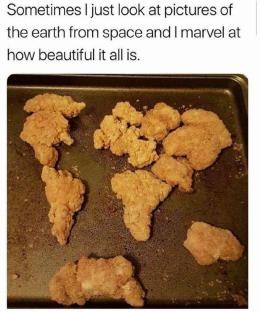

We can retrieve this image summary:

In [41]:
retriever.get_relevant_documents("Images / figures with playful and creative examples")[
    1
]

'The image features a close-up of a tray filled with various pieces of fried chicken. The chicken pieces are arranged in a way that resembles a map of the world, with some pieces placed in the shape of continents and others as countries. The arrangement of the chicken pieces creates a visually appealing and playful representation of the world, making it an interesting and creative presentation.\n\nmain: image encoded in   865.20 ms by CLIP (    1.50 ms per image patch)'

## RAG

Run [RAG pipeline](https://python.langchain.com/docs/expression_language/cookbook/retrieval).

For `option 1` (above): 

* Simply pass retrieved text chunks to LLM, as usual.

For `option 2a` (above): 

* We would pass retrieved image and images to the multi-modal LLM.
* This should be possible soon, once [llama-cpp-python add multi-modal support](https://github.com/abetlen/llama-cpp-python/issues/813).
* And, of course, this will be enabled by GPT4-V API.

In [42]:
from langchain_core.runnables import RunnablePassthrough

# Prompt template
template = """Answer the question based only on the following context, which can include text and tables:
{context}
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

# Option 1: LLM
model = ChatOpenAI(temperature=0, model="gpt-4")
# Option 2: Multi-modal LLM
# model = GPT4-V or LLaVA

# RAG pipeline
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [43]:
chain.invoke(
    "What is the performance of LLaVa across across multiple image domains / subjects?"
)

'The performance of LLaMA across multiple image domains/subjects is as follows: In the Natural Science (NAT) subject, it scored 84.37. In the Social Science (SOC) subject, it scored 88.30. In the Language Science (LAN) subject, it scored 84.36. In the Text Context (TXT) subject, it scored 83.72. In the Image Context (IMG) subject, it scored 80.32. In the No Context (NO) subject, it scored 86.90. For grades 1-6 (G1-6), it scored 85.83 and for grades 7-12 (G7-12), it scored 84.05. The average score was 85.19.'

We can check the [trace](https://smith.langchain.com/public/85a7180e-0dd1-44d9-996f-6cb9c6f53205/r) to see retrieval of tables and text.

In [49]:
chain.invoke("Explain images / figures with playful and creative examples.")

'The text provides an example of a playful and creative image. The image features a close-up of a tray filled with various pieces of fried chicken. The chicken pieces are arranged in a way that resembles a map of the world, with some pieces placed in the shape of continents and others as countries. The arrangement of the chicken pieces creates a visually appealing and playful representation of the world, making it an interesting and creative presentation.'